베이지안 통계학 과제2 
202485-010007 김동현

1. 정규분포 $X_1,\cdots,X_n|\mu\sim N(\mu,1)$의 평균 $\mu$에 대해 아래의 코시사전분포를 생각하자.
$$\mu\sim Cauchy(0,1)$$
(참고. $\mu=5, n=200$을 가정하고 표본 $X_1,\cdots,X_n$을 추출하여 다음의 물음에 답하시오.)

(a) 평균 $\mu$에 대한 사후분포를 구하시오.

$\mu$에 대한 사후분포는 다음과 같이 베이즈 정리에 따라 계산할 수 있다.

$\pi(\mu|X_i)\propto L(\mu|X_i)\cdot \pi(\mu)$

여기서 $L(\mu|X_i)$은 관측치의 가능도함수이다.
주어진 문제에서 관측치 $X_1,\cdots,X_n\sim N(\mu,1)$ 이므로 가능도 함수는 다음과 같다.

$L(\mu|X_i)=\prod_{i=1}^{n}f(X_i|\mu)\propto exp(-\dfrac{1}{2}\displaystyle\sum_{i=1}^{n}(X_i-\mu)^2)$

코시분포는 $\dfrac{1}{1+\mu^2}$ 에 비례한다.

$\pi(\mu)\propto \dfrac{1}{1+\mu^2}$

따라서 $\mu$에 대한 사후분포는 다음과 같이 나타낼 수 있다.

$\pi(\mu|X_i)\propto exp(-\dfrac{1}{2}\displaystyle\sum_{i=1}^{n}(X_i-\mu)^2)\cdot \dfrac{1}{1+\mu^2}$

(b) 몬테카를로 방법을 이용하여 사후평균을 계산하는 알고리즘을 작성하고 R로 구현하시오. 단 메트로폴리스-해스팅스 알고리즘은 사용하지 말 것.

In [188]:
# rjags 라이브러리 로드
library(rjags)
library(dplyr)
library(coda)
library(ggmcmc)

# JAGS 모델 정의
modelstring = "
    model {
    
    for (i in 1:n) {
        x[i] ~ dnorm(mu, 1) # 표준편차가 1인 정규분포
    }
  
    # 코시 사전분포
    mu ~ dt(0, 1, 1)  # Cauchy distribution (mean=0, scale=1)
    }
"


In [189]:
# 데이터 생성
n = 200
mu0 = 5
x = rnorm(n, mean = mu0, sd = 1)

# JAGS 모델 초기화
jags <- jags.model(textConnection(modelstring), data = list('x'=x, 'n'=n), n.chains = 4, n.adapt = 100)
post <- coda.samples(jags, c('mu'), n.iter=5000, thin=5)

Compiling model graph
   Resolving undeclared variables
   Allocating nodes
Graph information:
   Observed stochastic nodes: 200
   Unobserved stochastic nodes: 1
   Total graph size: 204

Initializing model




Iterations = 105:5100
Thinning interval = 5 
Number of chains = 4 
Sample size per chain = 1000 

1. Empirical mean and standard deviation for each variable,
   plus standard error of the mean:

          Mean             SD       Naive SE Time-series SE 
      5.090464       0.070562       0.001116       0.001095 

2. Quantiles for each variable:

 2.5%   25%   50%   75% 97.5% 
4.952 5.042 5.090 5.138 5.229 


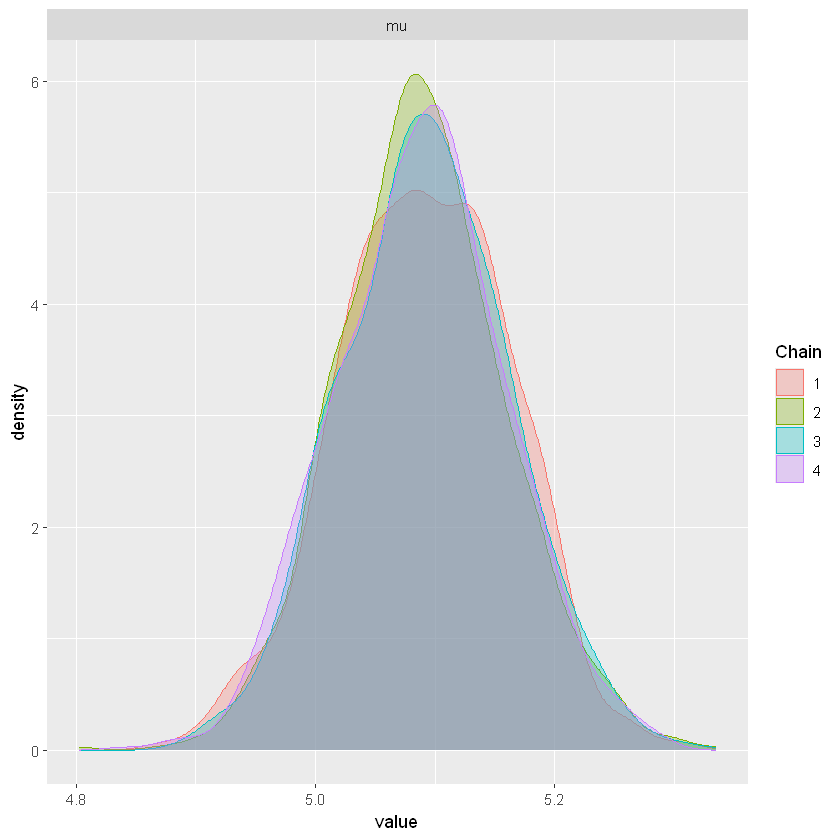

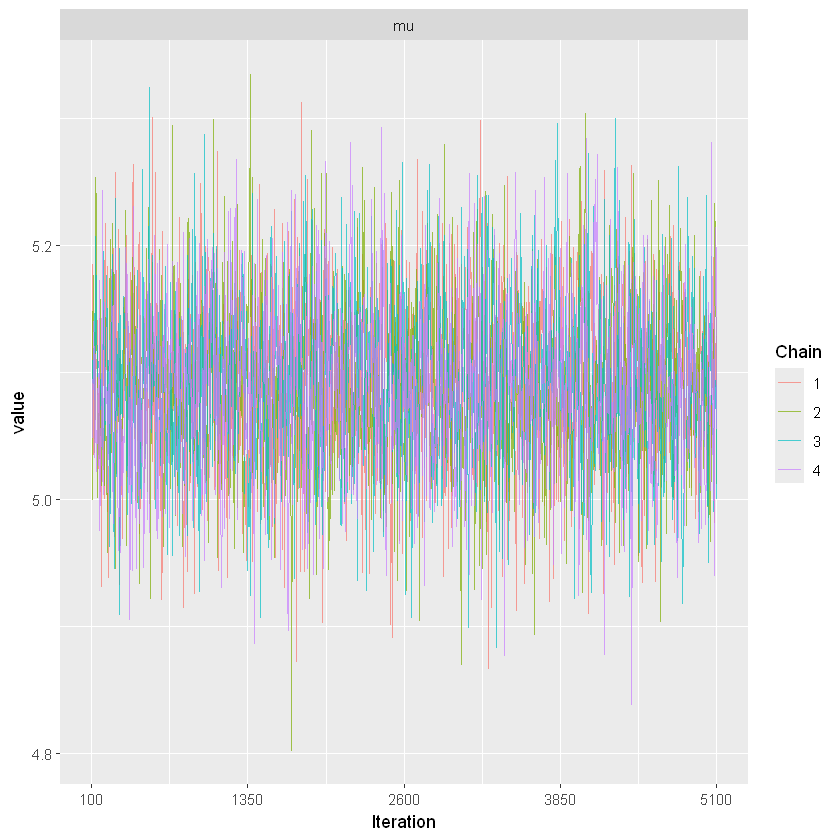

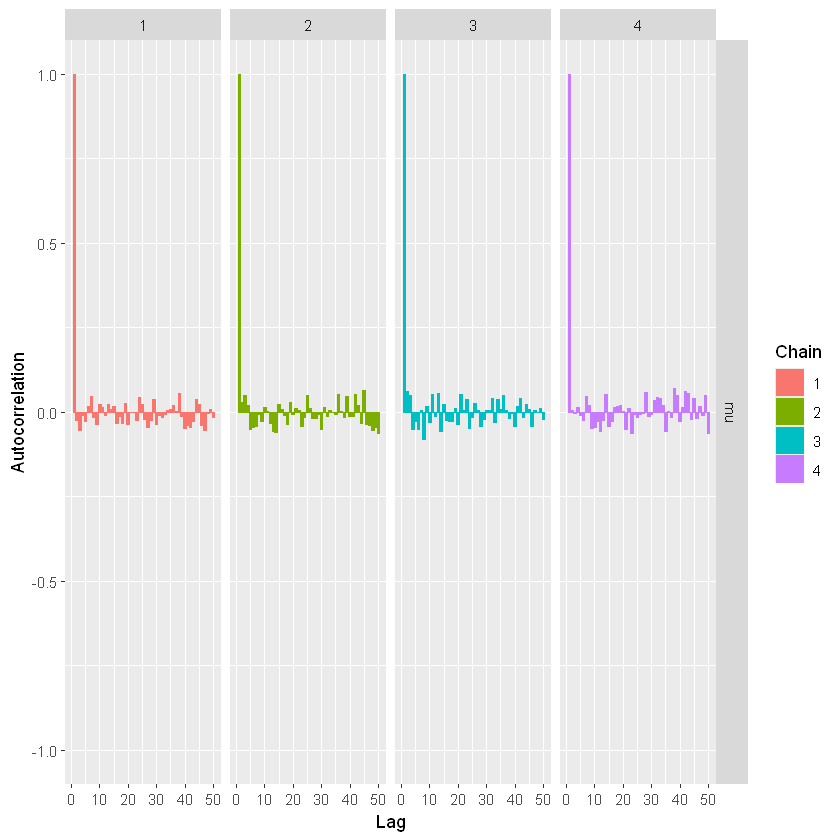

In [190]:
summary(post)
ggs_post <- ggs(post)
ggs_density(ggs_post)
ggs_traceplot(ggs_post)
ggs_autocorrelation(ggs_post)

(3) 메트로폴리스-해스팅스 알고리즘을 사용하여 추출한 사후표본을 이용하여 사후평균을 알고리즘을 작성하고 R로 구현하시오.

In [191]:
# 데이터 생성
n = 200  # 표본의 크기
mu0 = 5  # 실제 평균
x = rnorm(n, mean = mu0, sd = 1)  # 평균이 5이고 표준편차가 1인 정규분포에서 표본 추출

# Metropolis-Hastings 알고리즘 초기화
m = 50000  # 샘플링 반복 횟수
mu.jump = 2  # mu의 제안 분포 표준편차
mu = mean(x)  # 초기 mu 값 설정 (평균으로 초기화)

cat("초기 mu값:", mu, "\n")

초기 mu값: 5.048443 


In [192]:
po.mu = NULL  # 저장할 mu의 사후표본

# Metropolis-Hastings 알고리즘
for (j in 1:m) {
  # Step 1: mu에 대한 제안 값 muc 생성
  muc = rnorm(1, mu, mu.jump)
  
  # Step 2: Accept/Reject Step - mu
  log.accept.mu = sum(dnorm(x, mean = muc, sd = 1, log = TRUE)) - sum(dnorm(x, mean = mu, sd = 1, log = TRUE))
  u = runif(1, 0, 1)  # 0과 1 사이에서 균등분포로 u 값 생성
  
  # Step 3: Accept or Reject mu
  if (u < exp(log.accept.mu)) {
    mu = muc  # 제안된 값이 받아들여지면 mu 갱신
  }
  
  # Step 4: mu 값 저장
  po.mu = c(po.mu, mu)
}

# Thinning
thinning_interval = 10  # 10번 중 1번만 저장
po.mu_thinned = po.mu[seq(1, length(po.mu), by = thinning_interval)]

# 사후표본을 데이터프레임으로 변환
post.df = data.frame(mu = po.mu_thinned)

mean(po.mu_thinned)  # 사후평균 계산

[1] 5.048994


Iterations = 1:5000
Thinning interval = 1 
Number of chains = 1 
Sample size per chain = 5000 

1. Empirical mean and standard deviation for each variable,
   plus standard error of the mean:

          Mean             SD       Naive SE Time-series SE 
     5.0489935      0.0705410      0.0009976      0.0019497 

2. Quantiles for each variable:

 2.5%   25%   50%   75% 97.5% 
4.906 5.005 5.048 5.095 5.188 


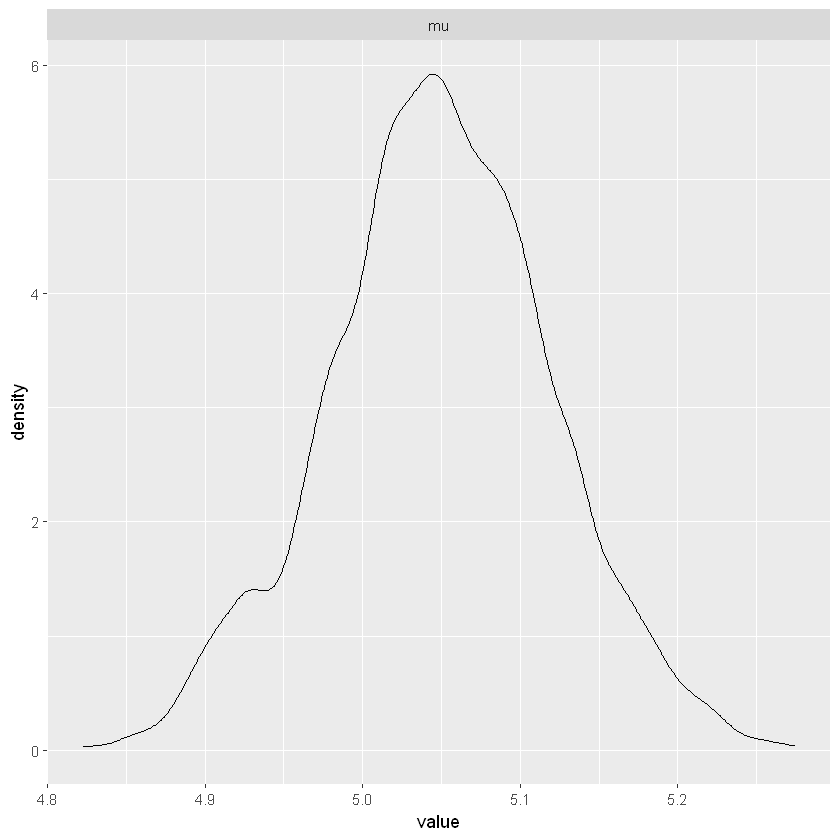

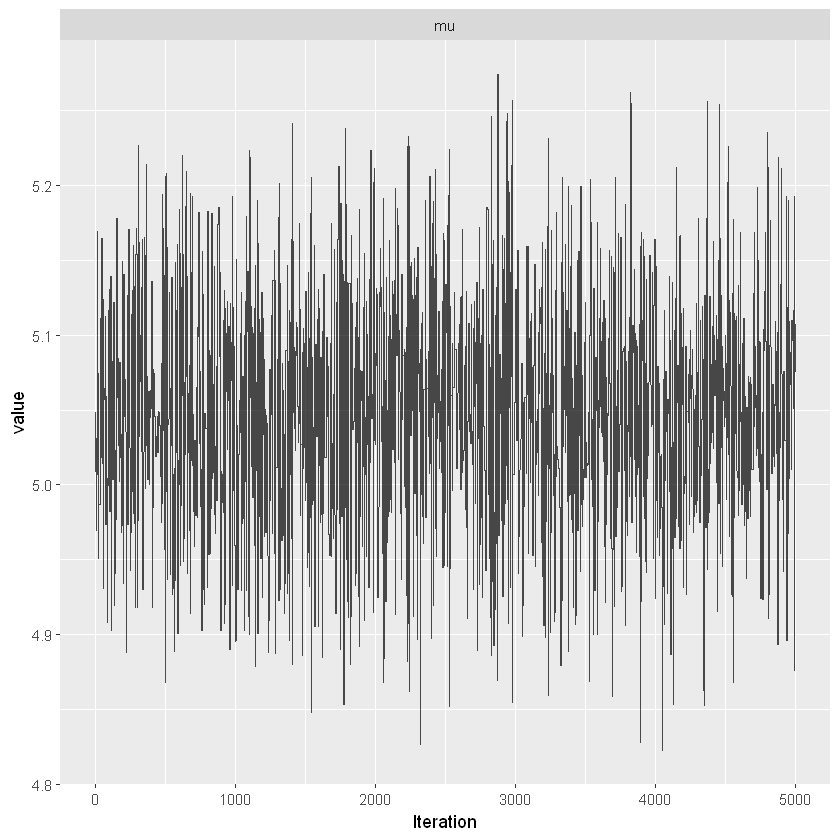

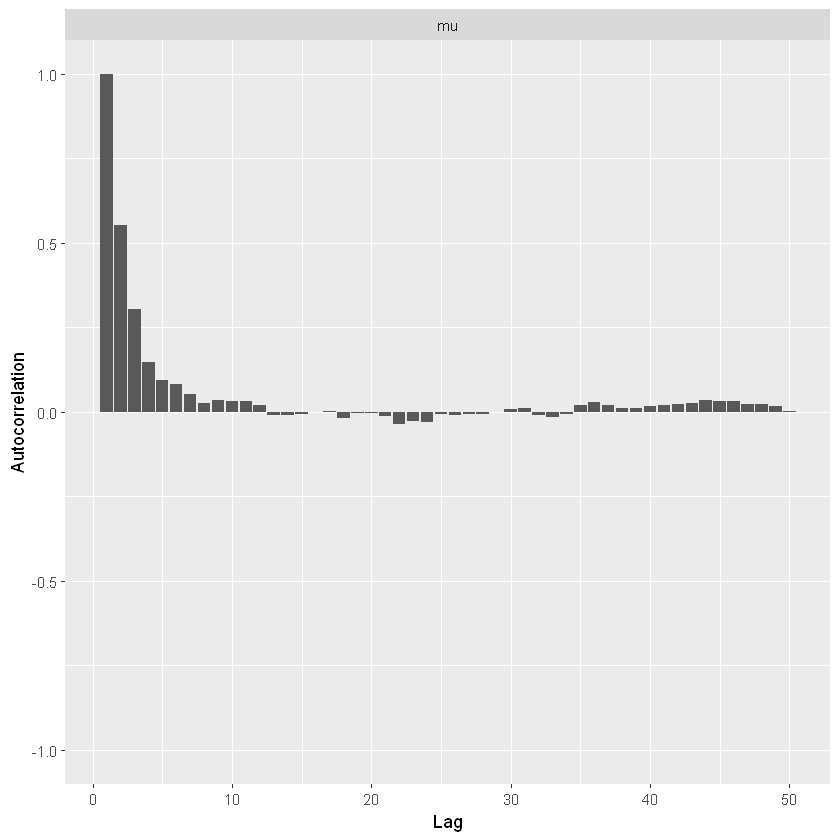

In [193]:
# 사후표본의 요약
post_mcmc <- as.mcmc(post.df)
summary(post_mcmc)

# 사후분포 시각화
post_ggs <- ggs(post_mcmc)
ggs_density(post_ggs) # 밀도 그래프
ggs_traceplot(post_ggs) # 추적 그래프
ggs_autocorrelation(post_ggs) # 자기상관 그래프

2. $X_1,\cdots,X_n|\mu,\sigma^2 \sim N(\mu,\sigma^2)$ 를 생각하자.  
   (참고. $\mu=5, \sigma^2=2, n=200$을 가정하고 표본 $X_1, \cdots, X_n$을 추출하여 다음의 물음에 답하시오.)

(a) 무정보적 사전분포를 이유와 함께 제시하시오.

- 평균에 대한 무정보 사전분포: 균등분포  
  - $p(\mu)\propto 1$
  - 사용이유: 평균에 대한 가정이 없다는 의미에서 어떤 값이라도 될 수 있는 균등분포를 사용한다.

- 분산에 대한 사전 분포: 역감마분포
  - $p(\sigma^2)\propto \dfrac{1}{\sigma^2}$
  - 사용이유
  ①분산 $\sigma^2$는 항상 양의 값이어야 하는데, 역감마분포는 $\sigma^2>0$인 값을 위한 분포로 정의되어 있다.  
  ②분산이 작은 값일수록 확률이 높고, 분산이 커질수록 확률이 점차 줄어드는 형태를 가지고 있어 실제 분산이 가지고 있는 특성을 잘 반영한다.
  ③켤레사전분포의 성질을 가지고 있어 계산을 간단하게 만들어 준다.   

(b) $\mu$와 $\sigma^2$에 대한 총조건부 사후분포를 구하고, 깁스표집법을 사용하여 사후표본을 추출하시오.

총조건부 사후분포는 여러 변수에 대해 각 변수의 조건부 사후분포를 결합한 사후분포를 의미한다.

따라서 총조건부 사후분포를 구하기 위해서는 우선 조건부 사후분포를 구해야 한다.

베이즈 정리: $\pi(\theta|X)\propto L(\theta|X)\cdot\pi(\theta)$

1. $\mu$에 대한 조건부 사후분포
- $\mu$에 대한 사전분포는 균등분포로 일정한 값을 가지므로 사후분포를 구하는데 있어서 사전분포가 영향을 미치지 않는다.
- 따라서, $\mu$의 사후분포는 가능도함수 만을 기준으로 구할 수 있다.  
$L(\mu,\sigma^2|X)=\displaystyle\prod_{i=1}^{n}\dfrac{1}{\sqrt{2\pi\sigma^2}}exp\left(-\dfrac{(X_i-\mu)^2}{2\sigma^2}\right)$  
$\hspace{3.5em}=\left(\dfrac{1}{\sqrt{2\pi\sigma^2}}\right)^n exp\left(-\dfrac{1}{2\sigma^2}\displaystyle\sum_{i=1}^{n}(X_i-\mu)^2\right)$

- $\mu$에 대한 조건부 사후분포를 구하기 위해 로그 가능도함수를 구한다.  
$log L(\mu|X,\sigma^2)=-\dfrac{n}{2}log(2\pi\sigma^2)-\dfrac{1}{2\sigma^2}\displaystyle\sum_{i=1}^{n}(X_i-\mu)^2$
- $\mu$에 대한 조건부 사후분포는 $\mu$에 대해 가능도함수를 최대화하는 분포이다.  
$\mu|X,\sigma^2\sim N\left(\dfrac{\sum_{i=1}^{n}X_i}{n},\dfrac{\sigma^2}{n}\right)$

2. $\sigma^2$에 대한 조건부 사후분포 유도
- $\mu$가 주어진 상태에서 $\sigma^2$에 대한 조건부 사후분포를 유도하려면 가능도함수와 사전분포를 결합해야 한다.
- 사전분포(역감마분포)는 다음과 같다.  
$p(\sigma^2)=\dfrac{\beta_0^{\alpha_0}}{\Gamma(\alpha_0)}(\sigma^2)^{\alpha_0-1}exp(-\dfrac{\beta_0}{\sigma^2})$
- 가능도함수와 사전분포를 결함하면 다음과 같다.  
$p(\sigma^2|X,\mu)\propto\left(\dfrac{1}{\sigma^2}\right)^{n/2}exp(-\dfrac{1}{2\sigma^2}\displaystyle\sum_{i=1}^{n}(X_i-\mu)^2)\cdot(\dfrac{1}{\sigma^2})^{\alpha_0+1}exp(-\dfrac{\beta_0}{\sigma^2})$
- 이를 정리하면, $\sigma^2$의 조건부 사후분포는 역감마분포가 된다.  
$\sigma^2|X,\mu\sim Inv-Gamma\left(\alpha_0+\dfrac{n}{2},\beta_0+\dfrac{1}{2}\displaystyle\sum_{i=1}^{n}(X_i-\mu)^2 \right)$

3. 총조건부 사후분포 유도

- 총조건부 사후분포는 두 조건부 사후분포를 결합한 형태이다.  
$p(\mu,\sigma^2|X)\propto p(\mu|X,\sigma^2)\cdot p(\sigma^2|X,\mu)$
- 총조건부 사후분포는 다음과 같다.  
$p(\mu,\sigma^2|X)\propto \left(\dfrac{1}{\sqrt{2\pi\sigma^2}} \right)^n exp\left(-\dfrac{1}{2\sigma^2} \displaystyle\sum_{i=1}^{n}(X_i-\mu)^2 \right)\cdot \dfrac{\beta_0^{\alpha_0}}{\Gamma(\alpha_0)}(\sigma^2)^{-\alpha_0-1} exp \left(-\dfrac{\beta_0}{\sigma^2} \right)$



In [194]:
# mu와 sigma^2에 대한 사후표본 추출하기
library(rjags)
library(dplyr)
library(coda)
library(ggmcmc)

modelstring <- "
    model {
        # 가능도함수
        for (i in 1:n) {
            X[i] ~ dnorm(mu, tau2)  # X는 정규분포를 따르며, mu는 평균, tau는 정규분포의 정밀도(1/분산)
        }

        # 사전분포
        mu ~ dnorm(0, 0.0001)  # mu에 대한 사전분포 (평균 0, 분산 매우 넓은 정규분포)
        tau2 ~ dgamma(0.001, 0.001)  # tau2(=1/sigma^2)에 대한 사전분포 (Inverse Gamma 분포)

        # 변환된 값
        sigma2 <- 1 / tau2  # sigma^2는 tau2의 역수입니다.
    }
"

In [195]:
# 예시 데이터 생성 (mu=5, sigma^2=2, n=200)
n <- 200
mu0 <- 5
sigma20 <- 2
X <- rnorm(n, mean = mu0, sd = sqrt(sigma20))  # 정규분포에서 샘플링

jags = jags.model(textConnection(modelstring), data=list('X'=X, 'n'=n), n.chains=4, n.adapt=100)
post_gibbs = coda.samples(jags, c('mu', 'sigma2'), n.iter=5000, thin=5)

Compiling model graph
   Resolving undeclared variables
   Allocating nodes
Graph information:
   Observed stochastic nodes: 200
   Unobserved stochastic nodes: 2
   Total graph size: 208

Initializing model




Iterations = 5:5000
Thinning interval = 5 
Number of chains = 4 
Sample size per chain = 1000 

1. Empirical mean and standard deviation for each variable,
   plus standard error of the mean:

        Mean     SD Naive SE Time-series SE
mu     4.870 0.1035 0.001637       0.001571
sigma2 2.191 0.2224 0.003517       0.003426

2. Quantiles for each variable:

        2.5%   25%   50%   75% 97.5%
mu     4.666 4.800 4.868 4.940 5.072
sigma2 1.795 2.037 2.173 2.325 2.673


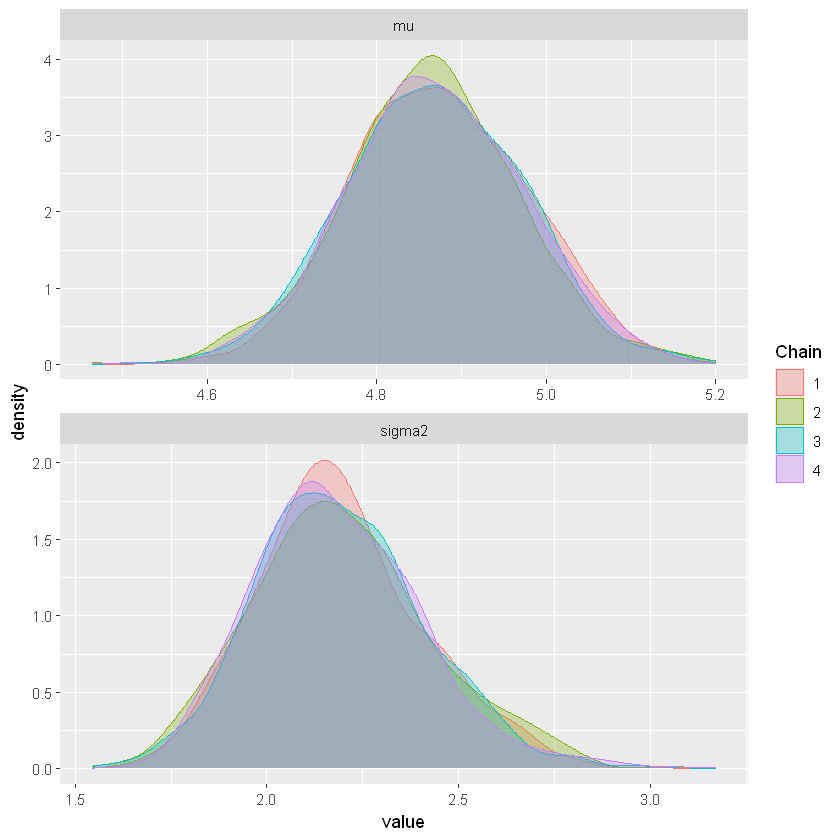

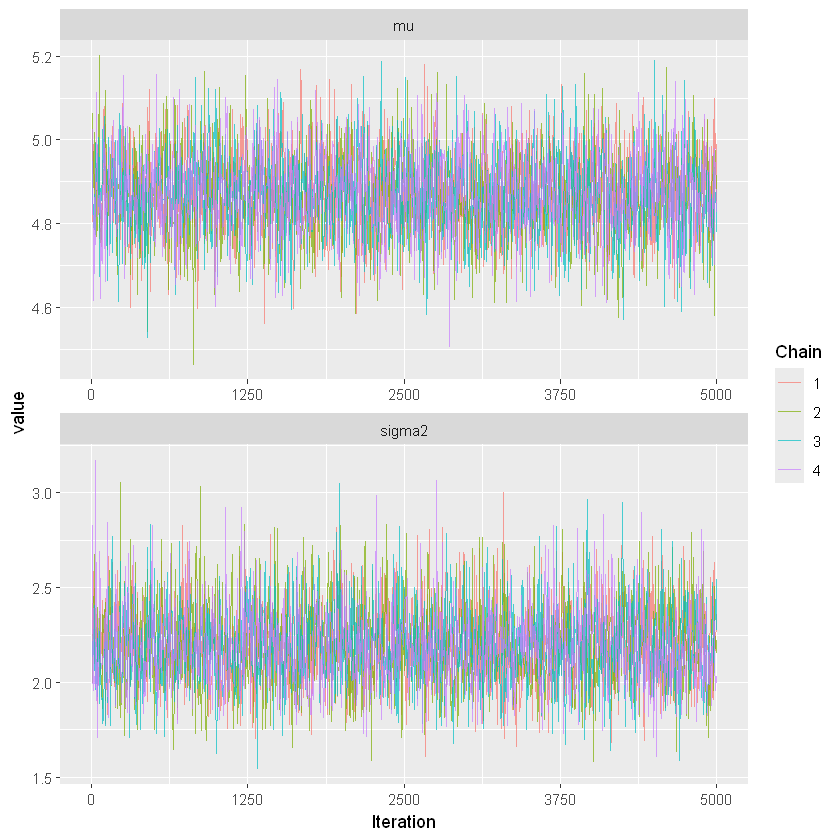

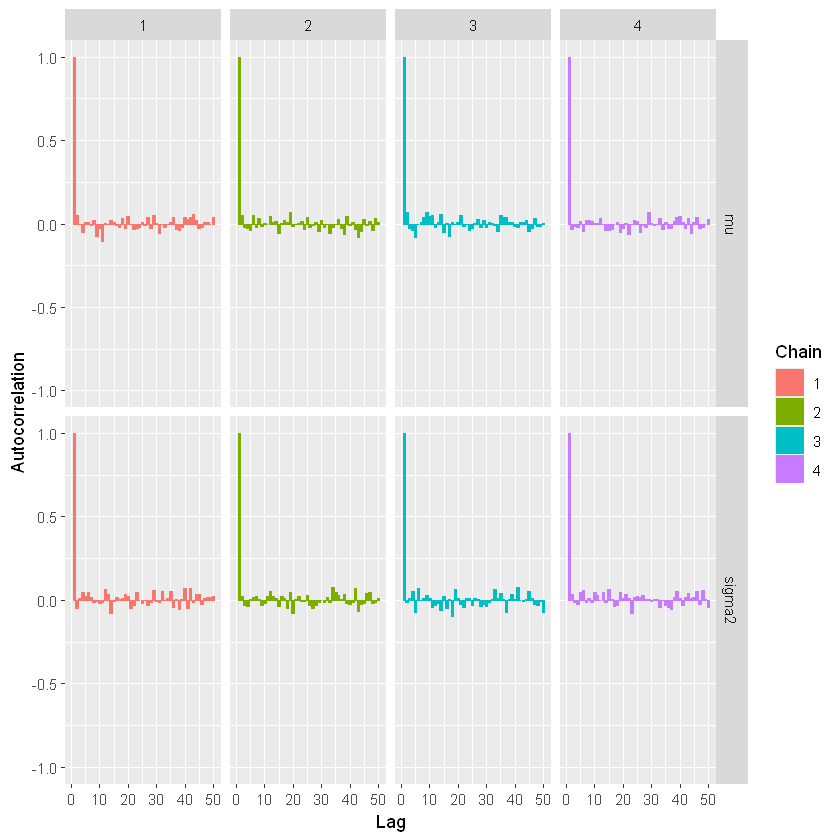

In [196]:
summary(post_gibbs)
ggs_post_gibbs <- ggs(post_gibbs)
ggs_density(ggs_post_gibbs)
ggs_traceplot(ggs_post_gibbs)
ggs_autocorrelation(ggs_post_gibbs)

(c) 임의 보행 메트로폴리스-헤이스팅스 알고리즘을 이용해 사후표본을 추출하시오.

In [197]:
# 데이터 생성
n = 200  # 표본의 크기
mu0 = 5  # 실제 평균
sigma20 = 2  # 실제 분산
x = rnorm(n, mean = mu0, sd = sqrt(sigma20))  # 평균이 5이고 분산이 2인 정규분포에서 표본 추출

# Metropolis-Hastings 알고리즘 초기화
m = 5000  # 샘플링 반복 횟수
mu.jump = 2  # mu의 제안 분포 표준편차
sigma2.jump = 2  # sigma^2의 제안 분포 표준편차
mu = mean(x)  # 초기 mu 값 설정 (평균으로 초기화)
sigma2 = var(x)  # 초기 sigma^2 값 설정 (초기값으로 샘플의 분산 사용)

cat("초기 mu값:", mu, "\n")
cat("초기 sigma^2값:", sigma2, "\n")

초기 mu값: 4.956319 
초기 sigma^2값: 2.323707 


In [198]:
po.mu = NULL  # 저장할 mu의 사후표본
po.sigma2 = NULL  # 저장할 sigma^2의 사후표본

# Metropolis-Hastings 알고리즘
for (j in 1:m) {
  # Step 1: mu에 대한 제안 값 muc 생성
  muc = rnorm(1, mu, mu.jump)
  
  # Step 2: sigma^2에 대한 제안 값 sigma2c 생성
  sigma2c = abs(rnorm(1, sigma2, sigma2.jump))  # 분산이 양수여야 하므로 절댓값을 취함
  
  # Step 3: Accept/Reject Step - mu
  log.accept.mu = sum(dnorm(x, mean = muc, sd = sqrt(sigma2), log = TRUE)) - sum(dnorm(x, mean = mu, sd = sqrt(sigma2), log = TRUE))
  
  # Step 4: Accept/Reject Step - sigma^2
  log.accept.sigma2 = sum(dnorm(x, mean = mu, sd = sqrt(sigma2c), log = TRUE)) - sum(dnorm(x, mean = mu, sd = sqrt(sigma2), log = TRUE)) +
                      dgamma(sigma2c, shape = 0.001, rate = 0.001, log = TRUE) - dgamma(sigma2, shape = 0.001, rate = 0.001, log = TRUE)

  # Step 5: Accept or Reject mu
  u = runif(1, 0, 1)  # 0과 1 사이에서 균등분포로 u 값 생성
  if (u < exp(log.accept.mu)) {
    mu = muc  # 제안된 값이 받아들여지면 mu 갱신
  }

  # Step 6: Accept or Reject sigma^2
  u = runif(1, 0, 1)  # 0과 1 사이에서 균등분포로 u 값 생성
  if (u < exp(log.accept.sigma2)) {
    sigma2 = sigma2c  # 제안된 값이 받아들여지면 sigma^2 갱신
  }

  # Step 7: mu와 sigma^2 값 저장
  po.mu = c(po.mu, mu)
  po.sigma2 = c(po.sigma2, sigma2)
}

# Thinning (5번 중 1번만 저장)
thinning_interval = 5 
po.mu_thinned = po.mu[seq(1, length(po.mu), by = thinning_interval)]
po.sigma2_thinned = po.sigma2[seq(1, length(po.sigma2), by = thinning_interval)]

# 사후표본을 데이터프레임으로 변환
post.df = data.frame(mu = po.mu_thinned, sigma2 = po.sigma2_thinned)

mean(po.mu_thinned)  # mu 사후평균 계산
mean(po.sigma2_thinned)  # sigma^2 사후평균 계산

[1] 4.953421

[1] 2.364486


Iterations = 1:1000
Thinning interval = 1 
Number of chains = 1 
Sample size per chain = 1000 

1. Empirical mean and standard deviation for each variable,
   plus standard error of the mean:

        Mean     SD Naive SE Time-series SE
mu     4.953 0.1125 0.003559        0.00654
sigma2 2.364 0.2511 0.007941        0.01191

2. Quantiles for each variable:

        2.5%   25%   50%   75% 97.5%
mu     4.719 4.883 4.955 5.029 5.175
sigma2 1.918 2.190 2.347 2.527 2.890


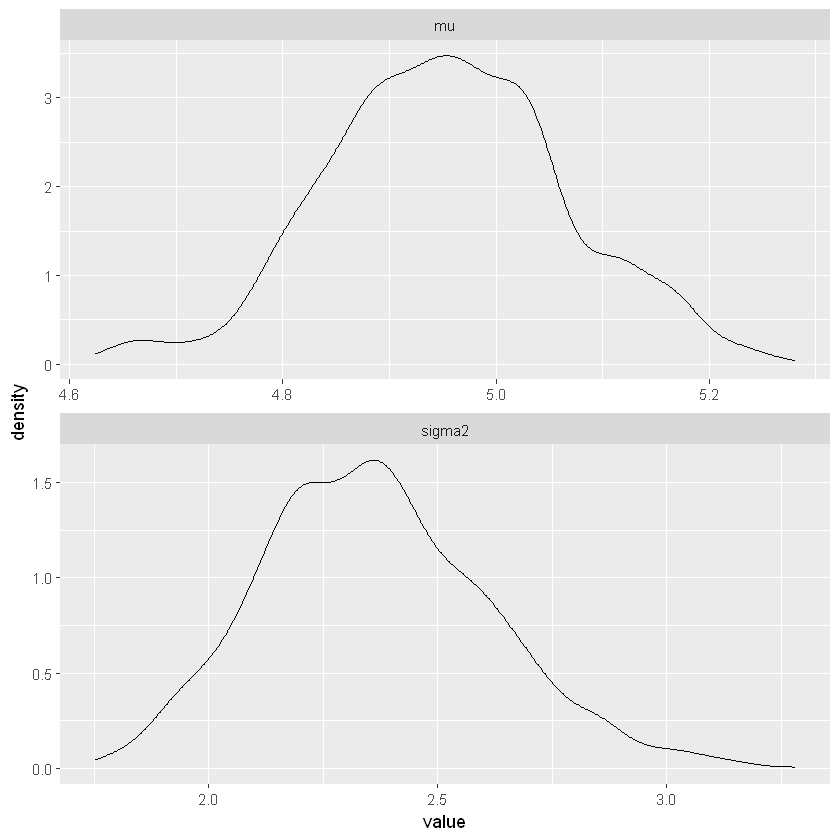

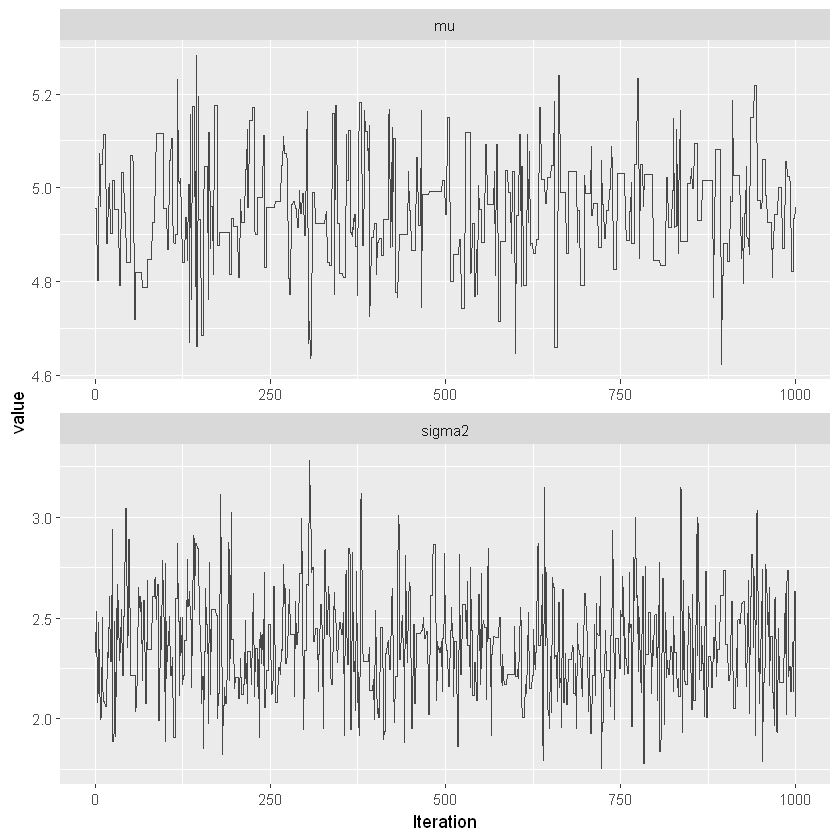

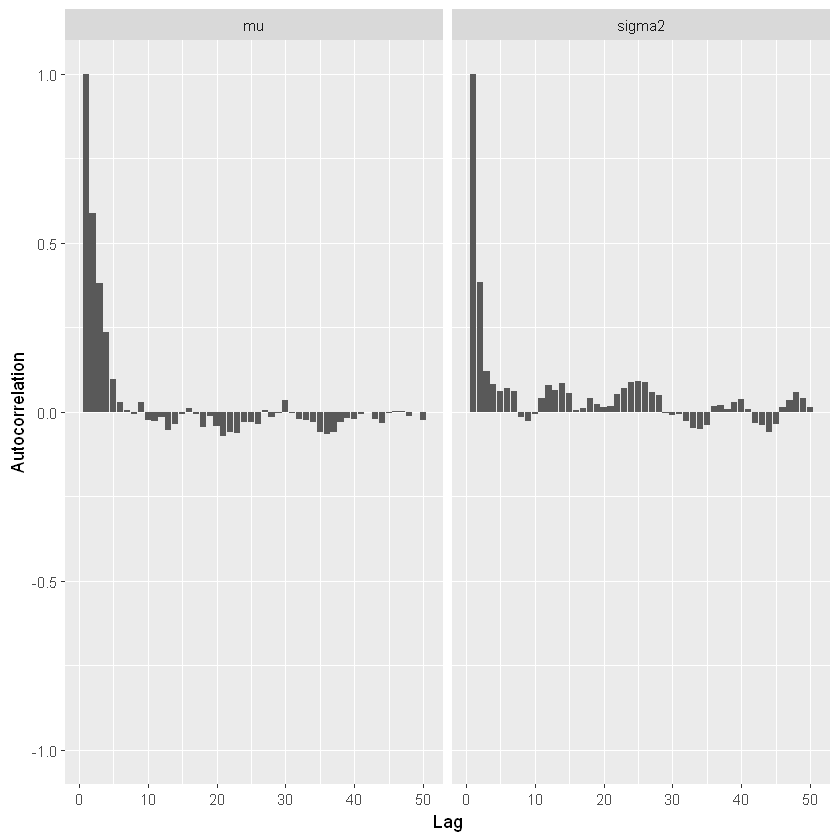

In [199]:
# 사후표본의 요약
post_mh <- as.mcmc(post.df)

summary(post_mh)
ggs_post_mh <- ggs(post_mh)
ggs_density(ggs_post_mh)
ggs_traceplot(ggs_post_mh)
ggs_autocorrelation(ggs_post_mh)


(d) 깁스표집법으로부터 얻은 사후표본의 밀도함수와 임의보행 메트로폴리스-헤이스팅스 알고리즘을 통해 얻은 사후표본의 밀도함수를 비교하시오.

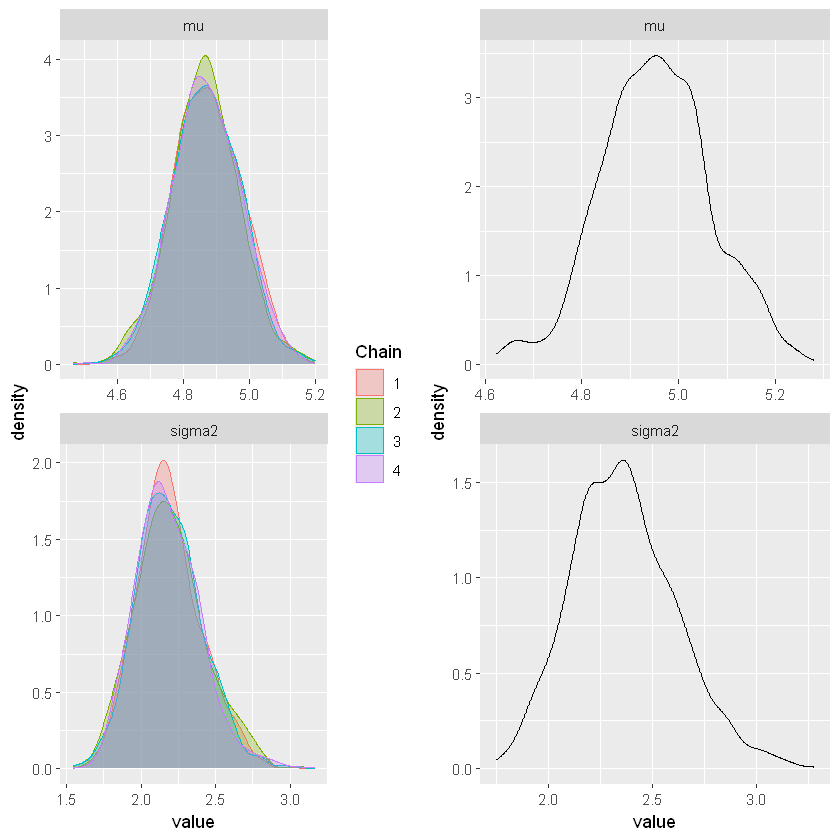

In [200]:
library(gridExtra)

plot_gibbs = ggs_density(ggs_post_gibbs)
plot_mh = ggs_density(ggs_post_mh)

# 두 그래프를 한 화면에 배치
grid.arrange(plot_gibbs, plot_mh, ncol = 2)

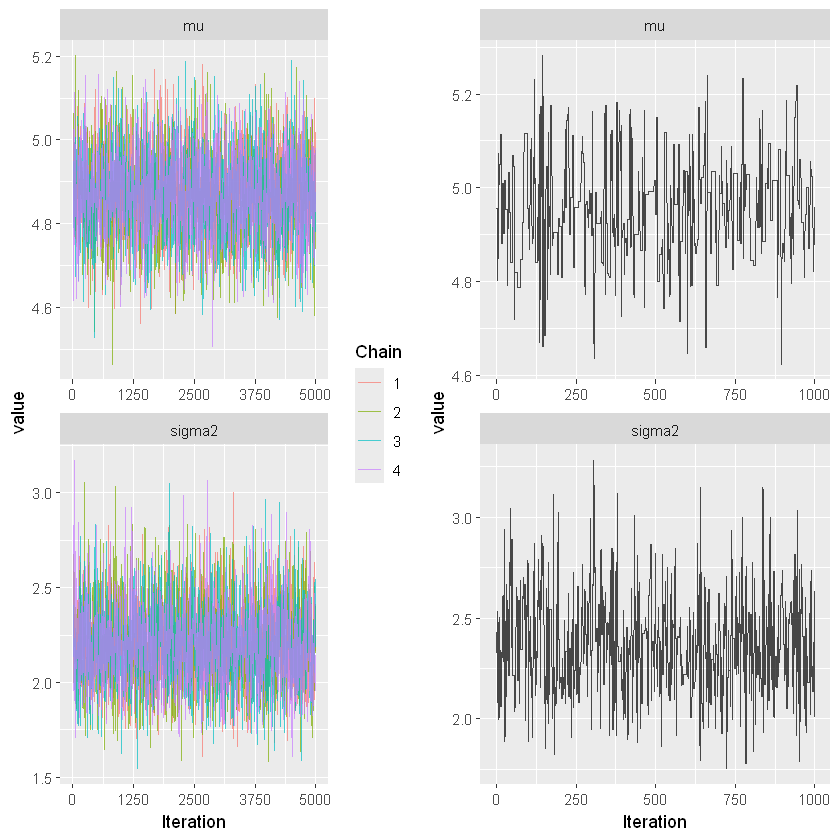

In [201]:
plot_gibbs = ggs_traceplot(ggs_post_gibbs)
plot_mh = ggs_traceplot(ggs_post_mh)

# 두 그래프를 한 화면에 배치
grid.arrange(plot_gibbs, plot_mh, ncol = 2)

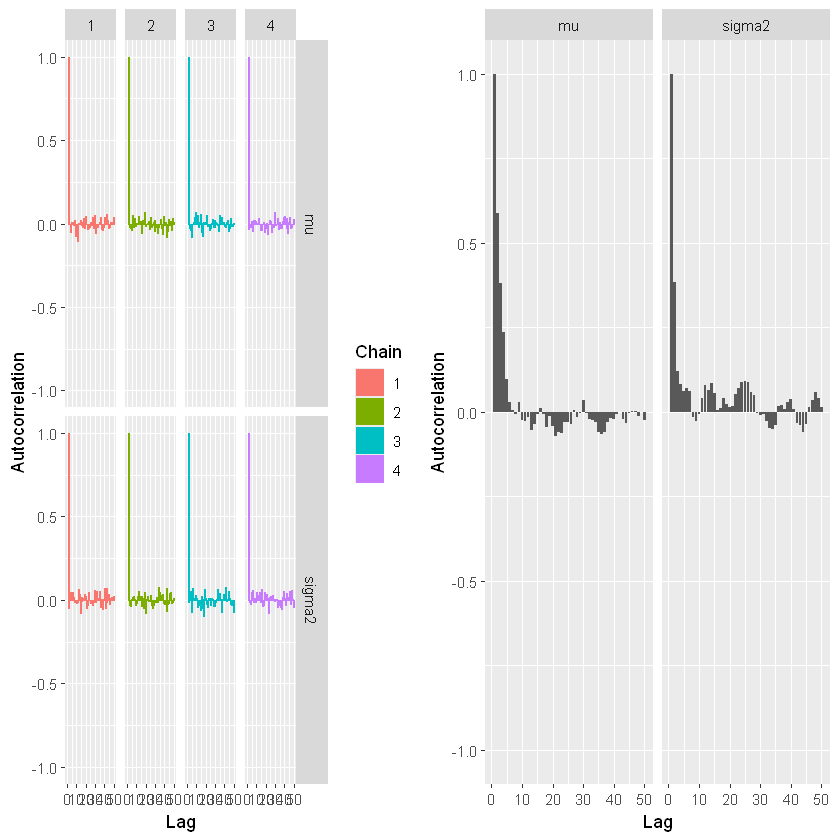

In [202]:
plot_gibbs = ggs_autocorrelation(ggs_post_gibbs)
plot_mh = ggs_autocorrelation(ggs_post_mh)

# 두 그래프를 한 화면에 배치
grid.arrange(plot_gibbs, plot_mh, ncol = 2)

깁스샘플링과 메트로폴리스-헤이스팅스 알고리즘은 둘 다 정상상태의 사후분포를 보여줍니다. 두 방법 사이에 큰 차이가 느껴지지 않습니다.  
다만, 같은 iteration과 thinning 조건임을 고려하면 깁스샘플링이 보다 더 규칙적이고 정규분포에 가까운 분포를 나타내는 경향이 있습니다.  
이는 조건부 분포에 대한 샘플링을 순차적으로 실시하는 깁스샘플링과, 보다 자유로운 샘플링 과정을 허용하는 MH 알고리즘의 차이라고 생각됩니다.   
하지만 수행할 때마다 결과가 달라지기 때문에 그러한 경향성이 유의하다고 보기는 어렵습니다.
